<a href="https://colab.research.google.com/github/asheta66/Machine-Learning-2024/blob/main/Classification/es_svm_for_clinic_heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Updated SVM + ES with SMOTE oversampling + confusion matrix subplot + saving figures

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, auc
)
from sklearn.utils import check_random_state

# For oversampling
!pip install -q imbalanced-learn
from imblearn.over_sampling import SMOTE

# --------------------------
# User settings / file path
# --------------------------
data_path = 'ClevelandDataSet.xlsx'  # Update path if needed

# --------------------------
# Load dataset and basic EDA
# --------------------------
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    df = pd.read_excel(path)
    return df

df = load_data(data_path)

# Age grouping
def age_grouping(df):
    bins = [-np.inf, 39, 54, np.inf]
    labels = ['Young', 'Middle-aged', 'Older']
    df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)
    return df

df = age_grouping(df)

print("AgeGroup counts before balancing:")
print(df['AgeGroup'].value_counts())

# Binary CHD target
df['CHD_binary'] = (df['Class'] != 0).astype(int)

# Prepare features and labels
exclude_cols = ['Class', 'CHD_binary', 'AgeGroup']
feature_cols = [c for c in df.columns if c not in exclude_cols]
X = df[feature_cols].copy()
y = df['CHD_binary'].copy()

# Handle missing values if any (median imputation)
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------
# Train/test split stratified by CHD_binary
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=22, stratify=y
)

print("\nClass distribution in training set BEFORE SMOTE:")
print(pd.Series(y_train).value_counts())

# --------------------------
# SMOTE oversampling on training set ONLY
# --------------------------
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nClass distribution in training set AFTER SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# --------------------------
# Evolution Strategies (ES) for hyperparameter tuning
# --------------------------
def evaluate_candidate(logC, logGamma, X, y, cv=5, random_state=0):
    C = 10**logC
    gamma = 10**logGamma
    svm = SVC(kernel='rbf', C=C, gamma=gamma, probability=False, random_state=random_state)
    cv_split = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    scores = cross_val_score(svm, X, y, cv=cv_split, scoring='accuracy', n_jobs=-1)
    return scores.mean()

def evolution_strategies(
    X, y, pop_size=20, generations=50, sigma_init=(1, 1),
    logC_bounds=(-3, 3), logG_bounds=(-4, 1), elite_frac=0.2, random_seed=42
):
    rng = check_random_state(random_seed)
    mu = int(np.ceil(pop_size * (1 - elite_frac)))
    pop = np.column_stack([
        rng.uniform(low=logC_bounds[0], high=logC_bounds[1], size=pop_size),
        rng.uniform(low=logG_bounds[0], high=logG_bounds[1], size=pop_size)
    ])
    sigma = np.array(sigma_init)
    best_history = []
    best_individual = None
    best_score = -np.inf

    for g in range(generations):
        fitness = np.array([evaluate_candidate(ind[0], ind[1], X, y, cv=5, random_state=random_seed) for ind in pop])
        idx_sorted = np.argsort(-fitness)
        pop = pop[idx_sorted]
        fitness = fitness[idx_sorted]

        if fitness[0] > best_score:
            best_score = fitness[0]
            best_individual = pop[0].copy()

        best_history.append(best_score)
        parents = pop[:mu]
        parent_mean = parents.mean(axis=0)
        offspring = parent_mean + rng.normal(loc=0.0, scale=sigma, size=(pop_size, 2))
        offspring[:,0] = np.clip(offspring[:,0], logC_bounds[0], logC_bounds[1])
        offspring[:,1] = np.clip(offspring[:,1], logG_bounds[0], logG_bounds[1])
        sigma = sigma * 0.99 + 0.01 * np.abs(rng.normal(size=sigma.shape))
        pop = offspring

        if (g+1) % 10 == 0 or g == 0:
            print(f"Generation {g+1}/{generations} - Best CV accuracy so far: {best_score:.4f}")

    return {
        'best_logC': best_individual[0],
        'best_logGamma': best_individual[1],
        'best_score': best_score,
        'history': best_history
    }

es_result = evolution_strategies(
    X_train_smote, y_train_smote,
    pop_size=20,
    generations=50,
    sigma_init=(0.6, 0.6),
    logC_bounds=(-3, 3),
    logG_bounds=(-4, 1),
    elite_frac=0.2,
    random_seed=42
)

best_C = 10**es_result['best_logC']
best_gamma = 10**es_result['best_logGamma']

print("\nES result:")
print(f"Best log10(C): {es_result['best_logC']:.4f} -> C = {best_C:.6f}")
print(f"Best log10(gamma): {es_result['best_logGamma']:.4f} -> gamma = {best_gamma:.6f}")
print(f"Best CV accuracy (train splits): {es_result['best_score']:.4f}")

# --------------------------
# Train final SVM on balanced training set
# --------------------------
final_svm = SVC(kernel='rbf', C=best_C, gamma= best_gamma, probability=True, random_state=42)
final_svm.fit(X_train_smote, y_train_smote)

y_train_pred = final_svm.predict(X_train_smote)
y_test_pred = final_svm.predict(X_test)

# --------------------------
# Confusion matrices (train & test)
# --------------------------
cm_train = confusion_matrix(y_train_smote, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# --------------------------
# Metrics table and classification report
# --------------------------
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return acc, prec, rec, f1

train_metrics = compute_metrics(y_train_smote, y_train_pred)
test_metrics = compute_metrics(y_test, y_test_pred)

metrics_df = pd.DataFrame(
    [train_metrics, test_metrics],
    columns=['accuracy', 'precision', 'recall', 'f1'],
    index=['train', 'test']
)
print("\nMetrics (train & test):")
metrics_df

# print("\nClassification report (TEST):")
# print(classification_report(y_test, y_test_pred, digits=4))

# --------------------------
# ROC curve plotting & saving
# --------------------------
y_train_prob = final_svm.predict_proba(X_train_smote)[:,1]
y_test_prob = final_svm.predict_proba(X_test)[:,1]

from sklearn.metrics import roc_curve, auc
fpr_train, tpr_train, _ = roc_curve(y_train_smote, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# --------------------------
# Save metrics and results to CSV
# --------------------------
results_folder = 'svm_es_smote_results'
os.makedirs(results_folder, exist_ok=True)
metrics_df.to_csv(os.path.join(results_folder, 'metrics_train_test.csv'))
pd.DataFrame({'generation_best_cv': es_result['history']}).to_csv(os.path.join(results_folder, 'es_history.csv'))
print(f"\nAll figures saved as PNG files in current directory, and CSV results saved in folder: {results_folder}")


AgeGroup counts before balancing:
AgeGroup
Older          159
Middle-aged    124
Young           14
Name: count, dtype: int64

Class distribution in training set BEFORE SMOTE:
CHD_binary
0    128
1    109
Name: count, dtype: int64

Class distribution in training set AFTER SMOTE:
CHD_binary
0    128
1    128
Name: count, dtype: int64
Generation 1/50 - Best CV accuracy so far: 0.8398
Generation 10/50 - Best CV accuracy so far: 0.8437
Generation 20/50 - Best CV accuracy so far: 0.8437
Generation 30/50 - Best CV accuracy so far: 0.8474
Generation 40/50 - Best CV accuracy so far: 0.8474
Generation 50/50 - Best CV accuracy so far: 0.8474

ES result:
Best log10(C): 0.2698 -> C = 1.861201
Best log10(gamma): -0.6803 -> gamma = 0.208770
Best CV accuracy (train splits): 0.8474

Metrics (train & test):

All figures saved as PNG files in current directory, and CSV results saved in folder: svm_es_smote_results


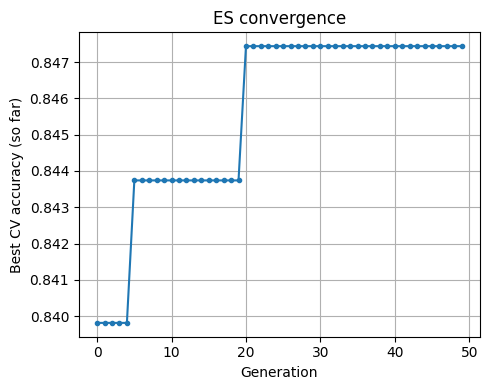

In [ ]:
# Plot ES convergence and save
plt.figure(figsize=(5,4))
plt.plot(es_result['history'], marker='.')
plt.xlabel('Generation')
plt.ylabel('Best CV accuracy (so far)')
plt.title('ES convergence')
plt.grid(True)
plt.tight_layout()
plt.savefig('es_convergence.png')
plt.show()

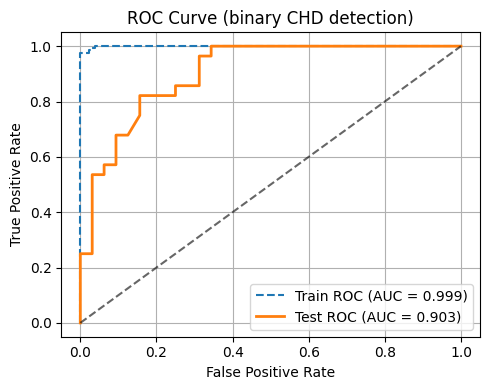

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {roc_auc_train:.3f})', linestyle='--')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {roc_auc_test:.3f})', linewidth=2)
plt.plot([0,1], [0,1], 'k--', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (binary CHD detection)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curve.png')
plt.show()

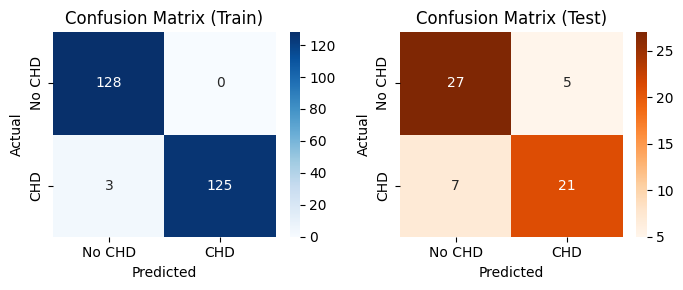

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(7,3))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Confusion Matrix (Train)')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')
axs[0].set_xticklabels(['No CHD', 'CHD'])
axs[0].set_yticklabels(['No CHD', 'CHD'])

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axs[1])
axs[1].set_title('Confusion Matrix (Test)')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
axs[1].set_xticklabels(['No CHD', 'CHD'])
axs[1].set_yticklabels(['No CHD', 'CHD'])

plt.tight_layout()
plt.savefig('confusion_matrices_train_test.png')
plt.show()

In [ ]:
metrics_df

,accuracy,precision,recall,f1
train,0.988281,1.000000,0.976562,0.988142
test,0.800000,0.807692,0.750000,0.777778


In [ ]:
df.describe()

,Age,Sex,CP,Trestbps,Chol,fbs,restecg,Thalach,Exang,Oldpeak,Slop,CA,thal,Class,CHD_binary
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640,0.946128,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,1.234551,0.499340
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000,1.000000


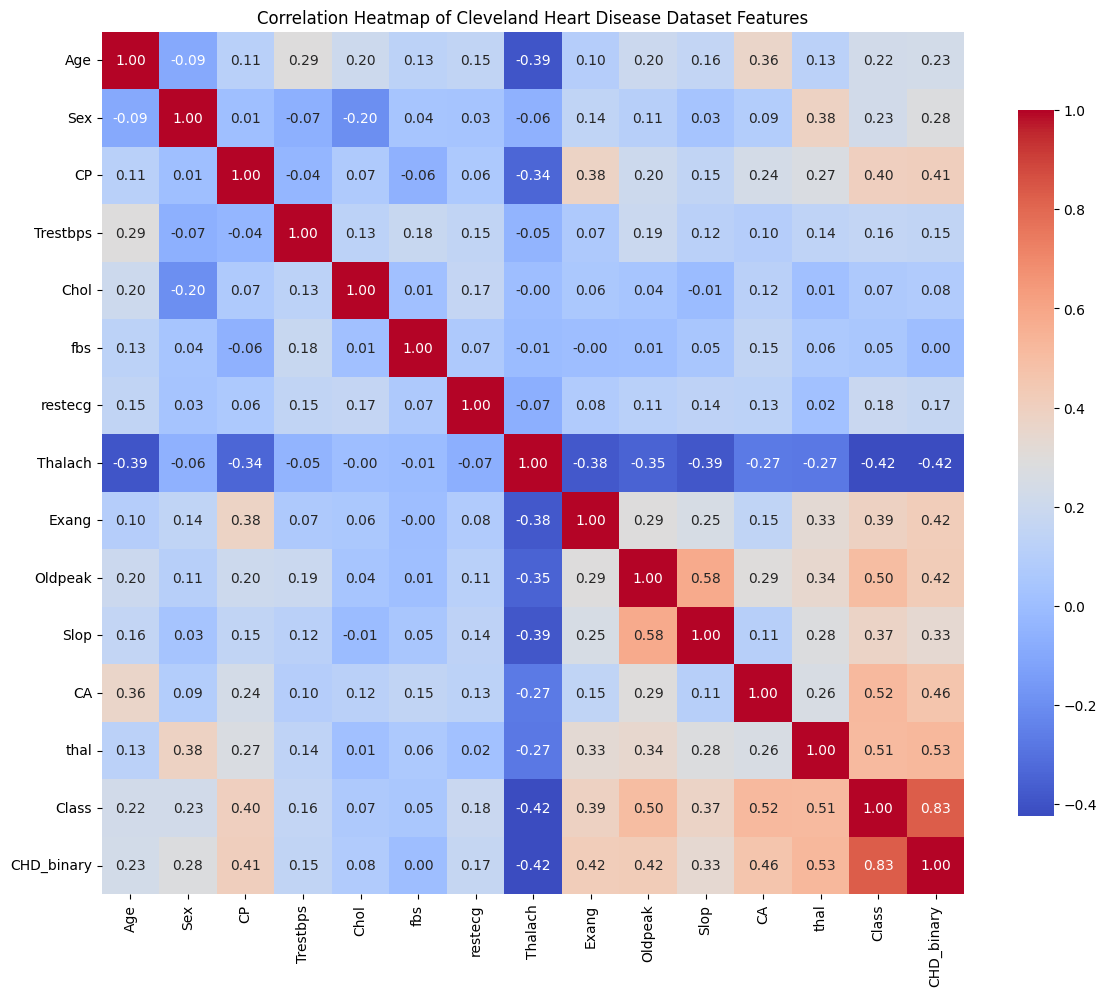

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming df is already loaded and preprocessed as before

# 1. Correlation matrix and heatmap
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

# Now compute correlation matrix on numeric data only
corr_matrix = numeric_df.corr()

# Plot heatmap as before
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap of Cleveland Heart Disease Dataset Features")
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

AgeGroup counts before balancing:
AgeGroup
Older          159
Middle-aged    124
Young           14
Name: count, dtype: int64

Class distribution in training set BEFORE SMOTE:
CHD_binary
0    128
1    109
Name: count, dtype: int64

Class distribution in training set AFTER SMOTE:
CHD_binary
0    128
1    128
Name: count, dtype: int64


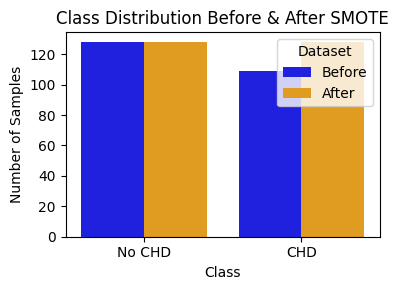

Generation 1/50 - Best CV accuracy so far: 0.8163
Generation 10/50 - Best CV accuracy so far: 0.8164
Generation 20/50 - Best CV accuracy so far: 0.8241
Generation 30/50 - Best CV accuracy so far: 0.8241
Generation 40/50 - Best CV accuracy so far: 0.8281
Generation 50/50 - Best CV accuracy so far: 0.8281

ES result:
Best log10(C): -0.8230 -> C = 0.150324
Best log10(gamma): -2.1022 -> gamma = 0.007903
Best CV accuracy (train splits): 0.8281


In [ ]:
# =========================
# SVM + Evolution Strategies + SMOTE
# =========================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc
)
from sklearn.utils import check_random_state

# For oversampling
!pip install -q imbalanced-learn
from imblearn.over_sampling import SMOTE

# --------------------------
# User settings / file path
# --------------------------
data_path = 'ClevelandDataSet.xlsx'  # Update path if needed

# --------------------------
# Load dataset
# --------------------------
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    df = pd.read_excel(path)
    return df

df = load_data(data_path)

# --------------------------
# Age grouping (optional)
# --------------------------
def age_grouping(df):
    bins = [-np.inf, 39, 54, np.inf]
    labels = ['Young', 'Middle-aged', 'Older']
    df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)
    return df

df = age_grouping(df)
print("AgeGroup counts before balancing:")
print(df['AgeGroup'].value_counts())

# --------------------------
# Binary CHD target
# --------------------------
df['CHD_binary'] = (df['Class'] != 0).astype(int)

# --------------------------
# Prepare features and labels
# --------------------------
exclude_cols = ['Class', 'CHD_binary', 'AgeGroup']
feature_cols = [c for c in df.columns if c not in exclude_cols]
X = df[feature_cols].copy()
y = df['CHD_binary'].copy()

# Handle missing values if any
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------
# Train/test split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=22, stratify=y
)

print("\nClass distribution in training set BEFORE SMOTE:")
print(pd.Series(y_train).value_counts())

# --------------------------
# SMOTE oversampling on training set ONLY
# --------------------------
smote = SMOTE(random_state=22)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nClass distribution in training set AFTER SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# --------------------------
# Plot class distributions BEFORE & AFTER SMOTE
# --------------------------
def plot_class_distribution(y_before, y_after, save_path='class_distribution_comparison.png'):
    counts_before = y_before.value_counts().sort_index()
    counts_after = y_after.value_counts().sort_index()
    df_plot = pd.DataFrame({
        'Class': ['No CHD', 'CHD']*2,
        'Count': np.concatenate([counts_before.values, counts_after.values]),
        'Dataset': ['Before']*2 + ['After']*2
    })
    plt.figure(figsize=(4,3))
    sns.barplot(data=df_plot, x='Class', y='Count', hue='Dataset', palette=['blue','orange'])
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution Before & After SMOTE', fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

plot_class_distribution(y_train, y_train_smote)

# --------------------------
# Evolution Strategies (ES) for hyperparameter tuning
# --------------------------
def evaluate_candidate(logC, logGamma, X, y, cv=5, random_state=0):
    C = 10**logC
    gamma = 10**logGamma
    svm = SVC(kernel='rbf', C=C, gamma=gamma, probability=False, random_state=random_state)
    cv_split = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    scores = cross_val_score(svm, X, y, cv=cv_split, scoring='accuracy', n_jobs=-1)
    return scores.mean()

def evolution_strategies(
    X, y, pop_size=20, generations=50, sigma_init=(1, 1),
    logC_bounds=(-3, 3), logG_bounds=(-4, 1), elite_frac=0.2, random_seed=42
):
    rng = check_random_state(random_seed)
    mu = int(np.ceil(pop_size * (1 - elite_frac)))
    pop = np.column_stack([
        rng.uniform(low=logC_bounds[0], high=logC_bounds[1], size=pop_size),
        rng.uniform(low=logG_bounds[0], high=logG_bounds[1], size=pop_size)
    ])
    sigma = np.array(sigma_init)
    best_history = []
    best_individual = None
    best_score = -np.inf

    for g in range(generations):
        fitness = np.array([evaluate_candidate(ind[0], ind[1], X, y, cv=5, random_state=random_seed) for ind in pop])
        idx_sorted = np.argsort(-fitness)
        pop = pop[idx_sorted]
        fitness = fitness[idx_sorted]

        if fitness[0] > best_score:
            best_score = fitness[0]
            best_individual = pop[0].copy()

        best_history.append(best_score)
        parents = pop[:mu]
        parent_mean = parents.mean(axis=0)
        offspring = parent_mean + rng.normal(loc=0.0, scale=sigma, size=(pop_size, 2))
        offspring[:,0] = np.clip(offspring[:,0], logC_bounds[0], logC_bounds[1])
        offspring[:,1] = np.clip(offspring[:,1], logG_bounds[0], logG_bounds[1])
        sigma = sigma * 0.99 + 0.01 * np.abs(rng.normal(size=sigma.shape))
        pop = offspring

        if (g+1) % 10 == 0 or g == 0:
            print(f"Generation {g+1}/{generations} - Best CV accuracy so far: {best_score:.4f}")

    return {
        'best_logC': best_individual[0],
        'best_logGamma': best_individual[1],
        'best_score': best_score,
        'history': best_history
    }

es_result = evolution_strategies(
    X_train_smote, y_train_smote,
    pop_size=20,
    generations=50,
    sigma_init=(0.6, 0.6),
    logC_bounds=(-3, 3),
    logG_bounds=(-4, 1),
    elite_frac=0.2,
    random_seed=22
)

best_C = 10**es_result['best_logC']
best_gamma = 10**es_result['best_logGamma']

print("\nES result:")
print(f"Best log10(C): {es_result['best_logC']:.4f} -> C = {best_C:.6f}")
print(f"Best log10(gamma): {es_result['best_logGamma']:.4f} -> gamma = {best_gamma:.6f}")
print(f"Best CV accuracy (train splits): {es_result['best_score']:.4f}")

# --------------------------
# Train final SVM
# --------------------------
final_svm = SVC(kernel='rbf', C=best_C, gamma=best_gamma, probability=True, random_state=42)
final_svm.fit(X_train_smote, y_train_smote)

y_train_pred = final_svm.predict(X_train_smote)
y_test_pred = final_svm.predict(X_test)

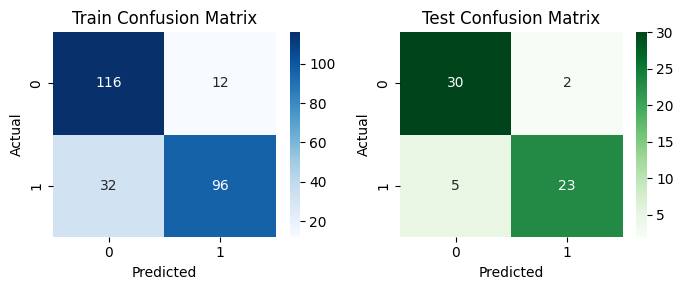


Metrics (train & test):
       accuracy  precision    recall        f1
train  0.828125   0.888889  0.750000  0.813559
test   0.883333   0.920000  0.821429  0.867925


In [ ]:
# --------------------------
# Confusion matrices
# --------------------------
cm_train = confusion_matrix(y_train_smote, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(7, 3))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Train Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Test Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

# --------------------------
# Metrics calculation
# --------------------------
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return acc, prec, rec, f1

train_metrics = compute_metrics(y_train_smote, y_train_pred)
test_metrics = compute_metrics(y_test, y_test_pred)

metrics_df = pd.DataFrame(
    [train_metrics, test_metrics],
    columns=['accuracy','precision','recall','f1'],
    index=['train','test']
)
print("\nMetrics (train & test):")
print(metrics_df)

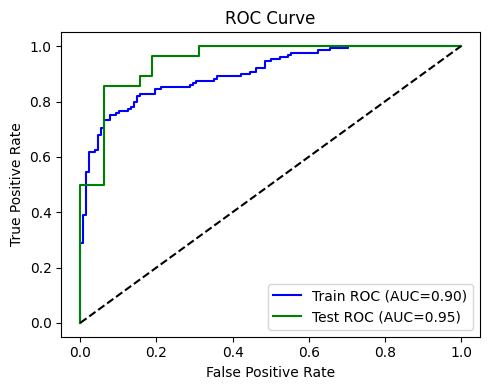


All figures saved, CSV metrics/results stored in folder: svm_es_smote_results


In [ ]:
# --------------------------
# ROC curves
# --------------------------
y_train_prob = final_svm.predict_proba(X_train_smote)[:,1]
y_test_prob = final_svm.predict_proba(X_test)[:,1]

fpr_train, tpr_train, _ = roc_curve(y_train_smote, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(5, 4))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC={roc_auc_train:.2f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC={roc_auc_test:.2f})', color='green')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.savefig('roc_curve.png')
plt.show()

# --------------------------
# Save results
# --------------------------
results_folder = 'svm_es_smote_results'
os.makedirs(results_folder, exist_ok=True)
metrics_df.to_csv(os.path.join(results_folder, 'metrics_train_test.csv'))
pd.DataFrame({'generation_best_cv': es_result['history']}).to_csv(os.path.join(results_folder, 'es_history.csv'))

print(f"\nAll figures saved, CSV metrics/results stored in folder: {results_folder}")

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_excel('ClevelandDataSet.xlsx')

# Print dataset size
print(f"Dataset size: {df.shape[0]} samples, {df.shape[1]} features")

# Count samples by disease presence
# Assuming 'Class' column where 0 = no disease, 1-4 = disease
no_disease_count = (df['Class'] == 0).sum()
disease_count = (df['Class'] != 0).sum()

print(f"No disease samples (Class=0): {no_disease_count}")
print(f"Disease samples (Class=1-4): {disease_count}")


Dataset size: 297 samples, 14 features
No disease samples (Class=0): 160
Disease samples (Class=1-4): 137



Comparison of Default vs. ES-Optimized SVM (TEST set):
                  accuracy  precision    recall        f1       auc
Default SVM       0.800000   0.833333  0.714286  0.769231  0.924107
ES-Optimized SVM  0.883333   0.920000  0.821429  0.867925  0.947545


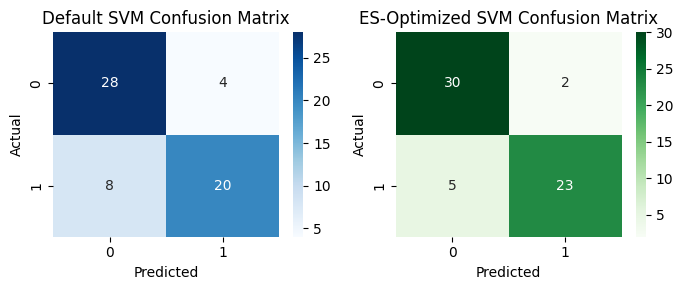

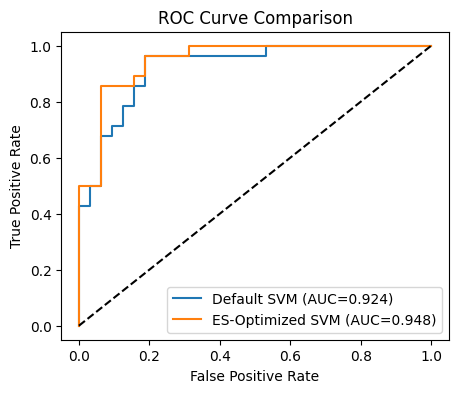

In [ ]:
# --------------------------
# Compare Default vs. ES-Optimized SVM
# --------------------------

# Default SVM
# default_svm = SVC(kernel='rbf', probability=True, random_state=42)

default_svm = SVC(kernel='rbf', probability=True, random_state=22)
default_svm.fit(X_train_smote, y_train_smote)

y_test_pred_default = default_svm.predict(X_test)
y_test_prob_default = default_svm.predict_proba(X_test)[:, 1]

# ES-Optimized SVM (already trained as final_svm)
y_test_pred_es = final_svm.predict(X_test)
y_test_prob_es = final_svm.predict_proba(X_test)[:, 1]

# Metrics function (reuse from above)
def compute_metrics(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = auc(fpr, tpr)
    return acc, prec, rec, f1, auc_score

default_metrics = compute_metrics(y_test, y_test_pred_default, y_test_prob_default)
es_metrics = compute_metrics(y_test, y_test_pred_es, y_test_prob_es)

comparison_df = pd.DataFrame(
    [default_metrics, es_metrics],
    columns=['accuracy', 'precision', 'recall', 'f1', 'auc'],
    index=['Default SVM', 'ES-Optimized SVM']
)

print("\nComparison of Default vs. ES-Optimized SVM (TEST set):")
print(comparison_df)

# --------------------------
# Confusion Matrices Side-by-Side
# --------------------------
cm_default = confusion_matrix(y_test, y_test_pred_default)
cm_es = confusion_matrix(y_test, y_test_pred_es)

fig, axes = plt.subplots(1, 2, figsize=(7, 3))
sns.heatmap(cm_default, annot=True, fmt='d', cmap="Blues", ax=axes[0])
axes[0].set_title("Default SVM Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_es, annot=True, fmt='d', cmap="Greens", ax=axes[1])
axes[1].set_title("ES-Optimized SVM Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.savefig("confusion_matrix_comparison.png")
plt.show()

# --------------------------
# ROC Curves Comparison
# --------------------------
fpr_default, tpr_default, _ = roc_curve(y_test, y_test_prob_default)
fpr_es, tpr_es, _ = roc_curve(y_test, y_test_prob_es)

plt.figure(figsize=(5, 4))
plt.plot(fpr_default, tpr_default, label=f"Default SVM (AUC={auc(fpr_default, tpr_default):.3f})")
plt.plot(fpr_es, tpr_es, label=f"ES-Optimized SVM (AUC={auc(fpr_es, tpr_es):.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.savefig("roc_curve_comparison.png")
plt.show()